In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
np.random.seed(12)

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100  # Increase animation size limit

class ImprovedSMPA(BaseEstimator, ClassifierMixin):
    """
    Smooth Manifold Projection Algorithm with improved boundary handling.
    This classifier uses a smooth spline boundary to separate binary classes in 2D.
    """

    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic'):
        """
        Initialize the SMPA classifier.

        Parameters:
        -----------
        learning_rate : float, default=0.005
            Initial learning rate for gradient updates
        epochs : int, default=50
            Maximum number of training epochs
        random_state : int, default=7
            Random seed for reproducibility
        verbose : bool, default=False
            Whether to print progress during training
        lambda_scaling : {'log', 'sqrt', 'none'}, default='log'
            Method to scale the update based on distance
        patience : int, default=5
            Epochs to wait before reducing learning rate
        decay_factor : float, default=0.5
            Factor to reduce learning rate by when patience is exceeded
        min_learning_rate : float, default=1e-6
            Minimum learning rate to stop training
        n_control_points : int, default=5
            Number of control points for the spline
        smoothing_factor : float, default=0.1
            Smoothing parameter for the spline
        spline_type : {'cubic', 'pchip'}, default='cubic'
            Type of spline to use ('pchip' preserves monotonicity better)
        """
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type

        # Validation
        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be one of 'cubic' or 'pchip'")

        # History tracking
        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []

        # Set random seed
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        """Calculate the mean point for each class."""
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)

    def _initialize_control_points(self, X):
        """Initialize control points with improved boundary handling."""
        # Data range with padding to prevent boundary issues
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        x_range = x_max - x_min
        y_range = y_max - y_min

        # Add padding outside data range for better boundary behavior
        x_min_extended = x_min - 0.2 * x_range
        x_max_extended = x_max + 0.2 * x_range

        # Create evenly spaced control points
        self.control_x = np.linspace(x_min_extended, x_max_extended, self.n_control_points)

        # Initialize control y values near the midpoint between class means
        y_mid = (self.m0[1] + self.m1[1]) / 2

        # Add slight randomization but keep endpoints stable
        self.control_y = np.random.uniform(
            y_mid - y_range * 0.05,
            y_mid + y_range * 0.05,
            self.n_control_points
        )

        # Make sure boundary control points have stable derivatives (flatter)
        # This helps prevent the spline from shooting up at the edges
        if self.n_control_points > 2:
            # Set the first and last control points to match second and second-to-last
            self.control_y[0] = self.control_y[1]
            self.control_y[-1] = self.control_y[-2]

        # Store initial control points for visualization
        self.initial_control_x = self.control_x.copy()
        self.initial_control_y = self.control_y.copy()
        self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

    def _fit_spline(self):
        """Fit a spline to the current control points with boundary constraints."""
        if self.spline_type == 'cubic':
            # Use cubic spline with clamped boundary conditions (zero derivative at endpoints)
            self.spline = CubicSpline(
                self.control_x,
                self.control_y,
                bc_type='clamped'  # This forces zero first derivative at endpoints
            )
        else:  # 'pchip'
            # PCHIP preserves monotonicity and reduces oscillations
            self.spline = PchipInterpolator(self.control_x, self.control_y)

    def _calculate_displacement(self, X):
        """Calculate vertical displacement from the spline."""
        spline_y = self.spline(X[:, 0])
        return X[:, 1] - spline_y

    def _update_pseudo_labels(self, X, y):
        """Determine which side of the spline each class should be on."""
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        """
        Fit the classifier to the training data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            Training data
        y : array-like, shape (n_samples,)
            Target values (0 or 1)

        Returns:
        --------
        self : object
            Returns self
        """
        # Validate inputs
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("This is a 2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)

        # Reset training history
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []
        self.error_history_ = []
        self.learning_rate_history_ = []

        # Initialize
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        # Track best model
        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None

        # Learning rate scheduling
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        # Pre-compute class indices for efficient updates
        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        # Main training loop
        for epoch in range(self.epochs):
            # Update spline and calculate errors
            self._fit_spline()
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            # Store history
            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)
            self.displacement_history.append(displacements.copy())
            self.error_index_history.append(np.where(errors)[0].copy())

            # Verbose logging
            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            # Update best model if improved
            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                # Learning rate decay
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            # Update control points based on errors
            if errors.any():
                error_indices = np.where(errors)[0]

                for idx in error_indices:
                    # Get the misclassified point
                    d = X[idx]

                    # Find nearest control point
                    distances = np.abs(self.control_x - d[0])
                    nearest_idx = np.argmin(distances)
                    distance = distances[nearest_idx]

                    # Scale update based on distance
                    if self.lambda_scaling == 'log':
                        lmbda = np.log1p(distance)
                    elif self.lambda_scaling == 'sqrt':
                        lmbda = np.sqrt(distance)
                    else:  # 'none'
                        lmbda = distance

                    # Adaptive margin: higher margins for points far from the decision boundary
                    margin = max(0.1, min(1.0, lmbda * 0.2))

                    # Determine opposite class's correctly classified points
                    if y[idx] == 1:  # Misclassified class 1 point
                        opp_indices = indices_class_0
                    else:  # Misclassified class 0 point
                        opp_indices = indices_class_1

                    # Find correctly classified points in opposite class
                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > margin]  # Use margin

                    # Calculate step direction
                    if len(correct_opp) > 0:
                        # Pick a random subset of correctly classified opposite class points
                        n_random = max(1, min(len(correct_opp) // 5, 5))  # Take 20%, max 5 points
                        random_correct = np.random.choice(correct_opp, size=n_random, replace=False)

                        # Average position of the random subset
                        random_avg_opp = np.mean(X[random_correct], axis=0)

                        # Calculate step direction toward this average
                        delta_x = random_avg_opp[0] - self.control_x[nearest_idx]
                        delta_y = random_avg_opp[1] - self.control_y[nearest_idx]

                        # Apply step with learning rate
                        step_x = delta_x * current_learning_rate / (1 + lmbda)
                        step_y = delta_y * current_learning_rate / (1 + lmbda)
                    else:
                        # Fallback: Move control point vertically to correct the error
                        step_x = 0
                        step_y = -pseudo_labels[idx] * margin * current_learning_rate

                    # Constrain step_x to maintain ascending order of control points
                    if nearest_idx > 0:
                        min_allowed_x = self.control_x[nearest_idx - 1] + 1e-6
                        max_step_left = self.control_x[nearest_idx] - min_allowed_x
                        step_x = max(step_x, -max_step_left)
                    if nearest_idx < len(self.control_x) - 1:
                        max_allowed_x = self.control_x[nearest_idx + 1] - 1e-6
                        max_step_right = max_allowed_x - self.control_x[nearest_idx]
                        step_x = min(step_x, max_step_right)

                    # Apply updates
                    self.control_x[nearest_idx] += step_x
                    self.control_y[nearest_idx] += step_y

                    # Special handling for boundary control points
                    # Keep first and last control points moving less to prevent boundary issues
                    if nearest_idx == 0 or nearest_idx == len(self.control_x) - 1:
                        # Scale down the step for boundary points
                        self.control_y[nearest_idx] *= 0.7  # Dampen movement at boundaries

                        # If it's the first control point, make second point match the derivative
                        if nearest_idx == 0 and len(self.control_x) > 2:
                            delta = self.control_y[1] - self.control_y[0]
                            self.control_y[0] = self.control_y[1] - 0.5 * delta

                        # If it's the last control point, make second-to-last point match the derivative
                        elif nearest_idx == len(self.control_x) - 1 and len(self.control_x) > 2:
                            delta = self.control_y[-1] - self.control_y[-2]
                            self.control_y[-1] = self.control_y[-2] + 0.5 * delta

            # Store control points after all updates
            self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

        # Store the last control points from the final epoch
        self.last_control_x = self.control_x.copy()
        self.last_control_y = self.control_y.copy()

        # Restore best model for prediction
        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        y : array-like, shape (n_samples,)
            The predicted classes (0 or 1)
        """
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        """
        Estimate probability of each class for samples in X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, 2)
            The input samples

        Returns:
        --------
        proba : array-like, shape (n_samples, 2)
            The class probabilities
        """
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)

        # Convert displacements to probabilities with sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        # Scale displacement to probability (use absolute displacement as confidence)
        raw_probs = sigmoid(displacements * self.class_1_pseudo * 0.5)

        # Create probability array [p(class=0), p(class=1)]
        if self.class_1_pseudo > 0:
            probs = np.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = np.column_stack([raw_probs, 1 - raw_probs])

        return probs

    def plot_convergence(self, figsize=(12, 5)):
        """Plot error and learning rate history."""
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

            # Plot error history
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)

            # Mark the best epoch
            if hasattr(self, 'best_epoch'):
                ax1.axvline(x=self.best_epoch, color='g', linestyle='--',
                            label=f'Best (Epoch {self.best_epoch})')

            # Plot learning rate history
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)

            plt.tight_layout()
            fig.legend()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def plot_boundary(self, X, y, figsize=(10, 8), padding_factor=0.1):
        """Plot decision boundary and training data."""
        try:
            fig = plt.figure(figsize=figsize)

            # Determine plot ranges
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            x_range = x_max - x_min
            y_range = y_max - y_min

            # Add padding
            x_min -= x_range * padding_factor
            x_max += x_range * padding_factor
            y_min -= y_range * padding_factor
            y_max += y_range * padding_factor

            # Create x-range for spline evaluation
            x_range_points = np.linspace(x_min, x_max, 500)

            # Scatter plot of data points
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, s=50, zorder=5)

            # Plot initial spline
            if hasattr(self, 'initial_control_x') and hasattr(self, 'initial_control_y'):
                if self.spline_type == 'cubic':
                    initial_spline = CubicSpline(self.initial_control_x, self.initial_control_y, bc_type='clamped')
                else:
                    initial_spline = PchipInterpolator(self.initial_control_x, self.initial_control_y)

                y_initial = initial_spline(x_range_points)
                plt.plot(x_range_points, y_initial, 'r--', label='Initial Boundary', alpha=0.7, zorder=1)

            # Plot best spline
            y_best = self.spline(x_range_points)
            plt.plot(x_range_points, y_best, 'g-', label='Best Boundary', linewidth=2, zorder=2)

            # Plot control points
            plt.scatter(self.initial_control_x, self.initial_control_y,
                        c='orange', marker='o', label='Initial Control Points', alpha=0.7, s=80, zorder=3)
            plt.scatter(self.control_x, self.control_y,
                        c='k', marker='x', label='Best Control Points', s=100, zorder=4)

            # Add class labels
            class0_idx = np.where(y == 0)[0]
            class1_idx = np.where(y == 1)[0]
            class0_center = np.mean(X[class0_idx], axis=0)
            class1_center = np.mean(X[class1_idx], axis=0)

            plt.annotate('Class 0', xy=(class0_center[0], class0_center[1]),
                        xytext=(class0_center[0] + x_range*0.05, class0_center[1] + y_range*0.05),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                        fontsize=12, fontweight='bold')

            plt.annotate('Class 1', xy=(class1_center[0], class1_center[1]),
                        xytext=(class1_center[0] - x_range*0.05, class1_center[1] - y_range*0.05),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                        fontsize=12, fontweight='bold')

            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.legend(loc='upper right')
            plt.title(f'ImprovedSMPA Decision Boundary ({self.spline_type} spline)')
            plt.grid(True, linestyle='--', alpha=0.3)

            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

    def animate_training(self, X, y, interval=200, save_path=None,
                     every_nth_epoch=1, figsize=(10, 8), padding_factor=0.1):
        """
        Create an animation of the spline's evolution during training.

        Parameters:
        -----------
        X, y : Training data
        interval : Time between frames in milliseconds
        save_path : If provided, save the animation to this path
        every_nth_epoch : Only show every nth epoch (to reduce animation size)
        figsize : Figure size
        padding_factor : Factor to add padding around the data

        Returns:
        --------
        Animation object that can be displayed in Jupyter/Colab
        """
        try:
            if not self.control_point_history:
                print("No training history found. Run fit() first.")
                return None

            # Set up the figure and axis
            fig, ax = plt.subplots(figsize=figsize)

            # Prepare data ranges with appropriate padding
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            x_range = x_max - x_min
            y_range = y_max - y_min

            x_min -= x_range * padding_factor
            x_max += x_range * padding_factor
            y_min -= y_range * padding_factor
            y_max += y_range * padding_factor

            # Create x-range for spline evaluation
            x_range_points = np.linspace(x_min, x_max, 200)

            # Scatter plot of the data (static)
            scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, s=50, zorder=5)

            # Initialize spline line and control points that will be updated
            spline_line, = ax.plot([], [], 'g-', lw=2, zorder=2)
            control_points = ax.scatter([], [], c='k', marker='x', s=100, zorder=4)

            # Error points highlighting
            error_points = ax.scatter([], [], color='yellow', edgecolor='black',
                                    marker='*', s=150, alpha=0.7, zorder=6)

            # Text for epoch counter and error count
            info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                            bbox=dict(facecolor='white', alpha=0.7))

            # Set up plot limits and labels
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'ImprovedSMPA Training Evolution ({self.spline_type} spline)')
            ax.grid(True, linestyle='--', alpha=0.3)

            # Only use a subset of epochs to make the animation manageable
            epochs_to_show = list(range(0, len(self.control_point_history), every_nth_epoch))

            def init():
                spline_line.set_data([], [])
                control_points.set_offsets(np.empty((0, 2)))
                error_points.set_offsets(np.empty((0, 2)))
                info_text.set_text('')
                return spline_line, control_points, error_points, info_text

            def update(frame_idx):
                epoch = epochs_to_show[frame_idx] if frame_idx < len(epochs_to_show) else 0
                if epoch >= len(self.control_point_history):
                    return spline_line, control_points, error_points, info_text

                # Get control points and fit spline
                control_x, control_y = self.control_point_history[epoch]
                try:
                    if self.spline_type == 'cubic':
                        spline = CubicSpline(control_x, control_y, bc_type='clamped')
                    else:
                        spline = PchipInterpolator(control_x, control_y)

                    y_spline = spline(x_range_points)

                    # Handle extreme values
                    mask = np.isfinite(y_spline) & (np.abs(y_spline) < 1e6)
                    if not np.all(mask):
                        # Replace extreme values with something reasonable
                        y_spline = np.clip(y_spline, y_min, y_max)
                        y_spline[~mask] = np.nan  # NaN values won't be plotted

                    # Update spline line
                    spline_line.set_data(x_range_points, y_spline)

                    # Update control points
                    control_points.set_offsets(np.column_stack((control_x, control_y)))

                    # Update error points if we have them
                    if epoch < len(self.error_index_history):
                        error_indices = self.error_index_history[epoch]
                        if len(error_indices) > 0:
                            error_points.set_offsets(X[error_indices])
                        else:
                            error_points.set_offsets(np.empty((0, 2)))

                    # Update info text
                    error_count = self.error_history_[epoch] if epoch < len(self.error_history_) else "N/A"
                    if hasattr(self, 'best_epoch') and epoch == self.best_epoch:
                        info_text.set_text(f'Epoch: {epoch} | Errors: {error_count} | BEST MODEL')
                        info_text.set_bbox(dict(facecolor='lightgreen', alpha=0.7))
                    else:
                        info_text.set_text(f'Epoch: {epoch} | Errors: {error_count}')
                        info_text.set_bbox(dict(facecolor='white', alpha=0.7))
                except Exception as e:
                    print(f"Error in frame {frame_idx} (epoch {epoch}): {e}")
                    # Keep previous state in case of error

                return spline_line, control_points, error_points, info_text

            # Create the animation
            ani = animation.FuncAnimation(fig, update, frames=len(epochs_to_show),
                                        init_func=init, blit=True, interval=interval)

            # Save if requested
            if save_path:
                ani.save(save_path, writer='pillow', dpi=100)
                print(f"Animation saved to {save_path}")

            plt.close(fig)  # Close the figure to avoid displaying it twice
            return ani

        except ImportError as e:
            print(f"Error: {e}. Make sure you have matplotlib installed.")
            return None

In [4]:
def generate_blob_dataset(n_points=400, noise=0.2):
    X, y = make_blobs(n_samples=n_points, random_state=7, cluster_std=noise, centers = 2)
    return X, y

class ClassifierComparison:
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        # We won't create a single split upfront anymore
        # but will keep track of class distribution for reference
        self.grids = {
            'smpa': {
                'learning_rate': [0.002, 0.001, 0.005],
                'epochs': [500, 600],
                'n_control_points': [3, 4, 5, 6],
                'decay_factor': [0.99, 0.999],
                'lambda_scaling': ['log', 'sqrt'],
                'patience' : [5, 10],
            },
            'svm': {
                'C': [0.1, 1, 10, 50, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf']
            },
            'rf': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20],
                'min_samples_split': [2, 5]
            },
            'dt': {
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5]
            }
        }
        # Define scaler types but don't fit them yet
        self.scaler_types = {
            'smpa': MinMaxScaler(feature_range=(-100, 100)),
            'svm': StandardScaler(),
            'rf': StandardScaler(),
            'dt': StandardScaler()
        }

    def create_train_test_split(self, seed):
        """Create a fresh train-test split with the given random seed"""
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=seed, stratify=self.y
        )
        print(f"Train Class Dist - {np.bincount(y_train)}")
        print(f"Test Class Dist - {np.bincount(y_test)}")
        return X_train, X_test, y_train, y_test

    def scale_data(self, X_train, X_test, classifier_type):
        """Scale data using a fresh scaler for the given classifier type"""
        # Create a new scaler instance of the appropriate type
        scaler = self.scaler_types[classifier_type].__class__(**self.scaler_types[classifier_type].get_params())
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def grid_search(self, X_train_scaled, y_train, classifier_type='smpa', seed=0):
        """Perform grid search with the provided scaled training data"""
        classifiers = {
            'smpa': ImprovedSMPA(random_state=seed),
            'svm': SVC(random_state=seed),
            'rf': RandomForestClassifier(random_state=seed),
            'dt': DecisionTreeClassifier(random_state=seed),
        }
        clf = classifiers[classifier_type]
        param_grid = self.grids[classifier_type]
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
        grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        return grid_search

    def stability_test(self, classifier_type='smpa', n_runs=50):
        scores = []
        best_params_list = []

        for seed in range(n_runs):
            print(f"\nRun {seed} for {classifier_type}...")

            # Create a fresh train-test split for each run
            X_train, X_test, y_train, y_test = self.create_train_test_split(seed)

            # Scale the data for this specific split
            X_train_scaled, X_test_scaled = self.scale_data(X_train, X_test, classifier_type)

            # Grid search on this fresh train split with newly scaled data
            grid_search = self.grid_search(X_train_scaled, y_train, classifier_type, seed)
            clf = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            print(f"Run {seed} Best Params: {grid_search.best_params_}")

            try:
                y_pred = clf.predict(X_test_scaled)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
                if classifier_type == 'smpa':
                    # Plot with the same scaled data used for training
                    clf.plot_boundary(X_train_scaled, y_train)
                    clf.plot_convergence()
                    ani = clf.animate_training(X_train_scaled, y_train, save_path = f"./animations/{seed}.gif")
                    plt.show()
                print(f"Run {seed} Score: {score:.4f}")
            except Exception as e:
                print(f"🚨 Error in run {seed}: {e}")
                scores.append(0)

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'scores': scores,
            'best_params_list': best_params_list
        }

    def statistical_significance_test(self, baseline_scores_dict, target='smpa'):
        target_scores = baseline_scores_dict[target]['scores']
        for clf_type, results in baseline_scores_dict.items():
            if clf_type != target:
                t_stat, p_val = stats.ttest_ind(target_scores, results['scores'])
                print(f"\n🔬 {target} vs. {clf_type}:")
                print(f"T-Statistic: {t_stat:.4f}")
                print(f"P-Value: {p_val:.4f}")
                print("🏆 Significant difference!" if p_val < 0.05 else "🤝 No significant difference.")

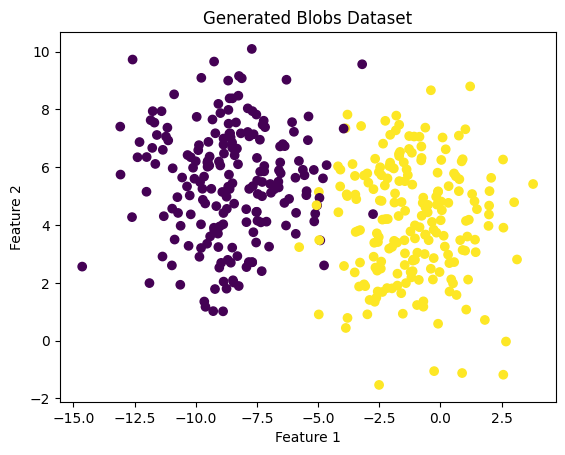

In [6]:
X, y = generate_blob_dataset(n_points=400, noise=2)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()


Run 0 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Run 0 Best Params: {'decay_factor': 0.99, 'epochs': 500, 'lambda_scaling': 'log', 'learning_rate': 0.001, 'n_control_points': 4, 'patience': 5}
Animation saved to ./animations/0.gif


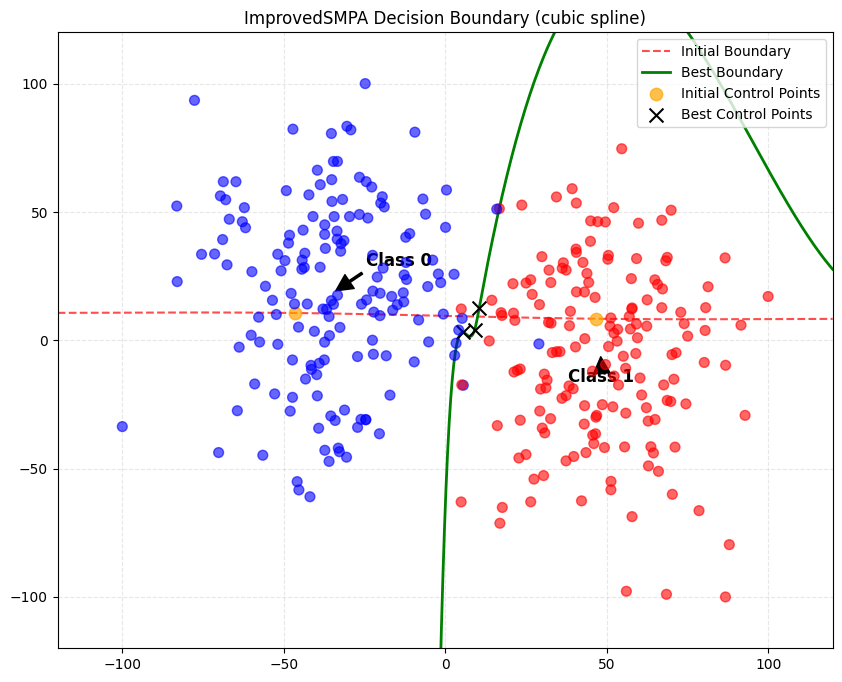

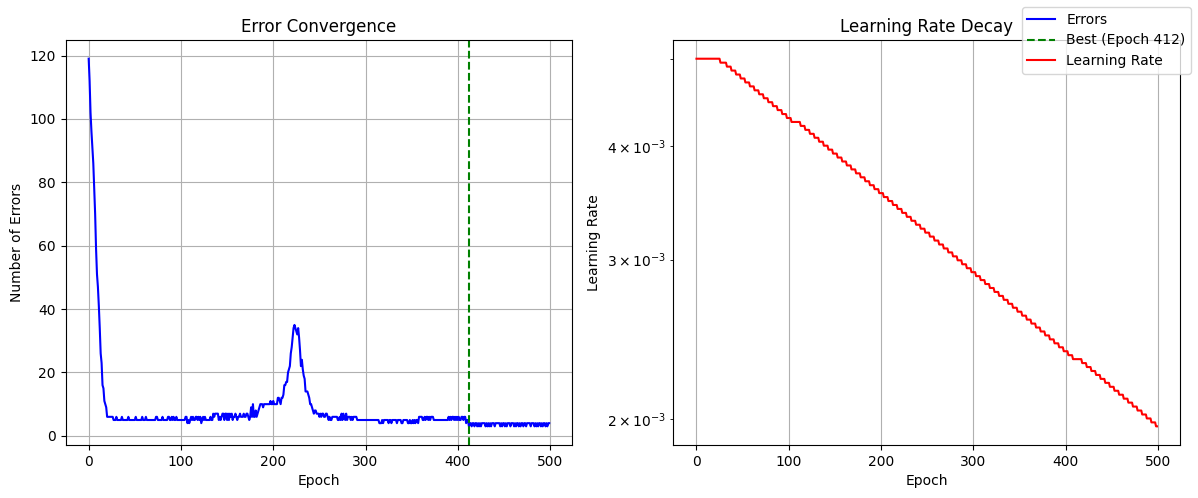

Run 0 Score: 0.9500

Run 1 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Run 1 Best Params: {'decay_factor': 0.99, 'epochs': 500, 'lambda_scaling': 'log', 'learning_rate': 0.002, 'n_control_points': 5, 'patience': 5}
Animation saved to ./animations/1.gif


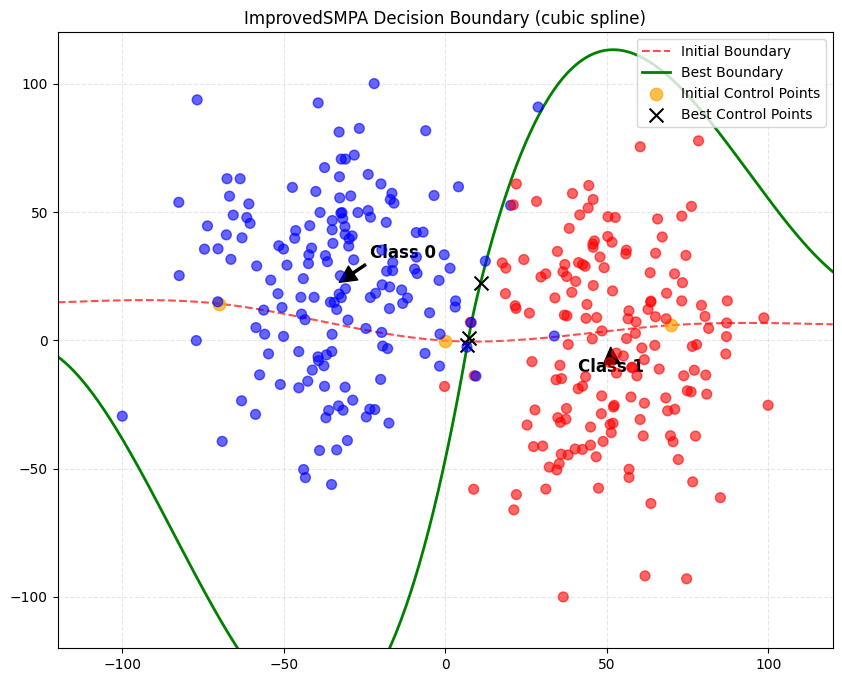

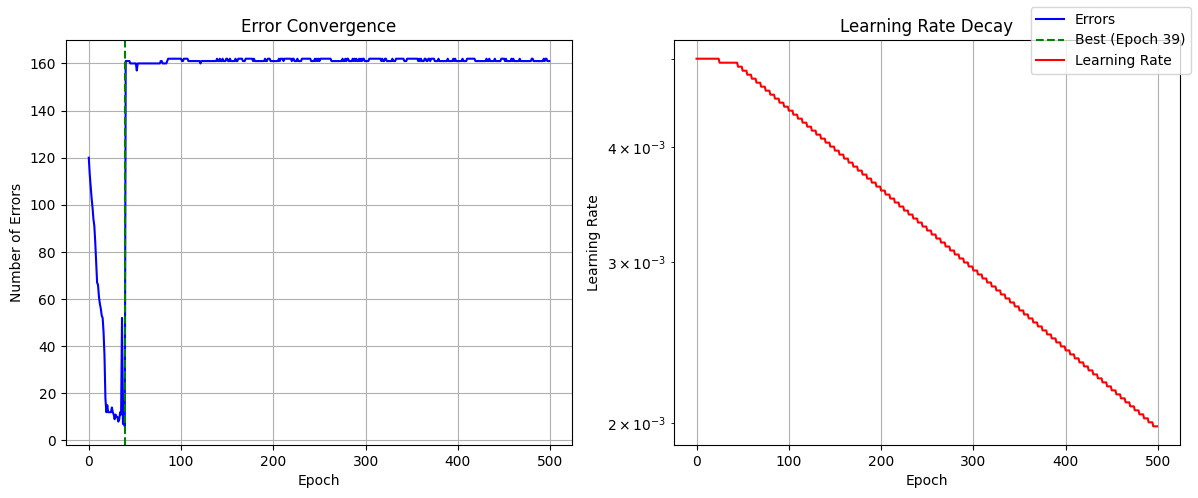

Run 1 Score: 0.9625

Run 2 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Run 2 Best Params: {'decay_factor': 0.99, 'epochs': 600, 'lambda_scaling': 'sqrt', 'learning_rate': 0.001, 'n_control_points': 4, 'patience': 10}
Animation saved to ./animations/2.gif


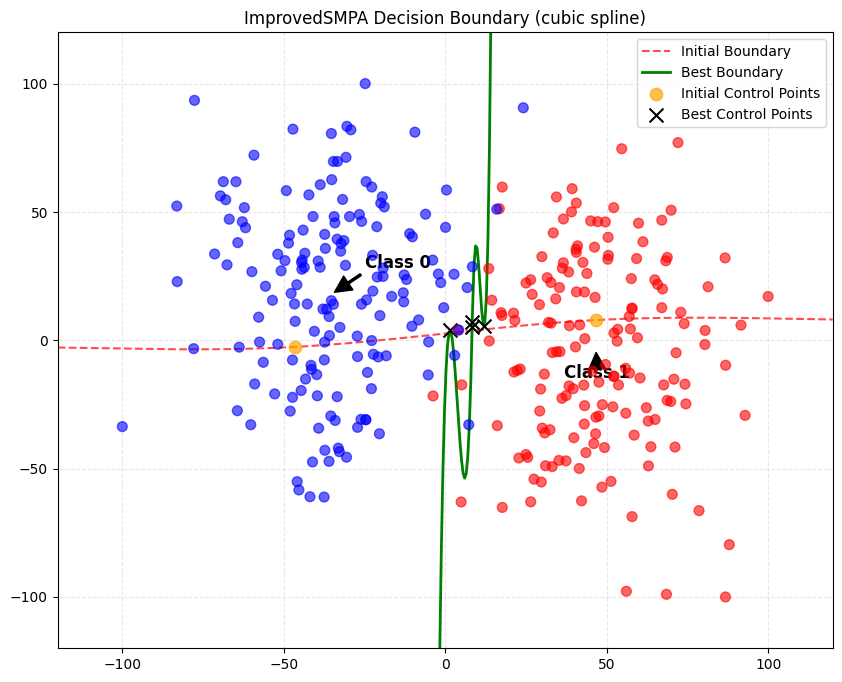

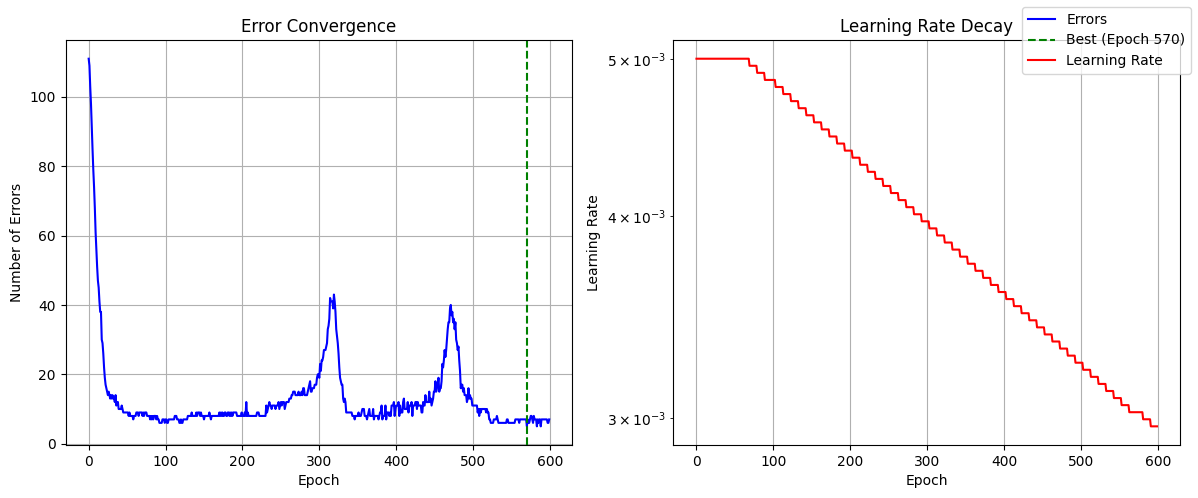

Run 2 Score: 0.9750

Run 3 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Run 3 Best Params: {'decay_factor': 0.999, 'epochs': 500, 'lambda_scaling': 'sqrt', 'learning_rate': 0.005, 'n_control_points': 6, 'patience': 5}
Animation saved to ./animations/3.gif


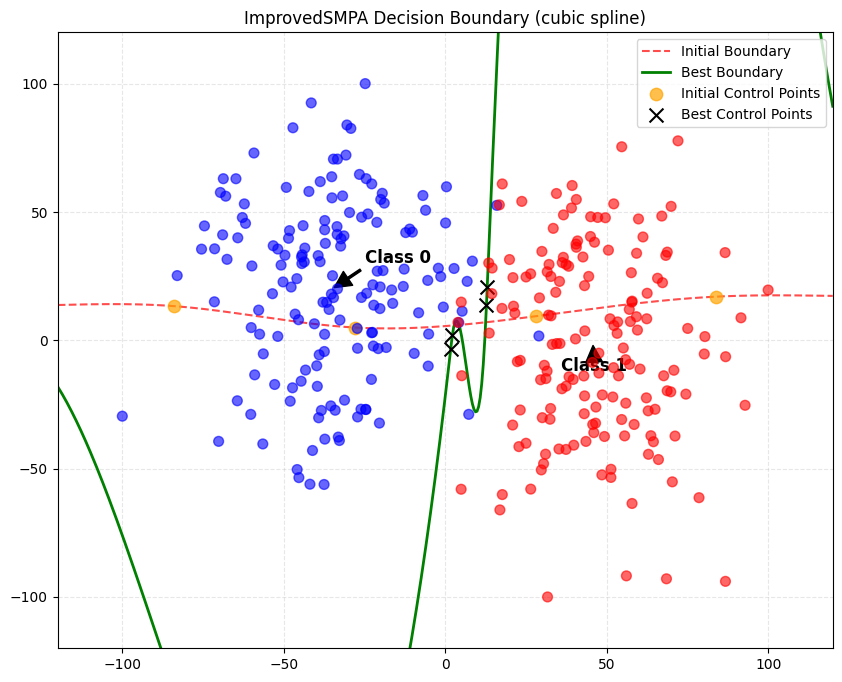

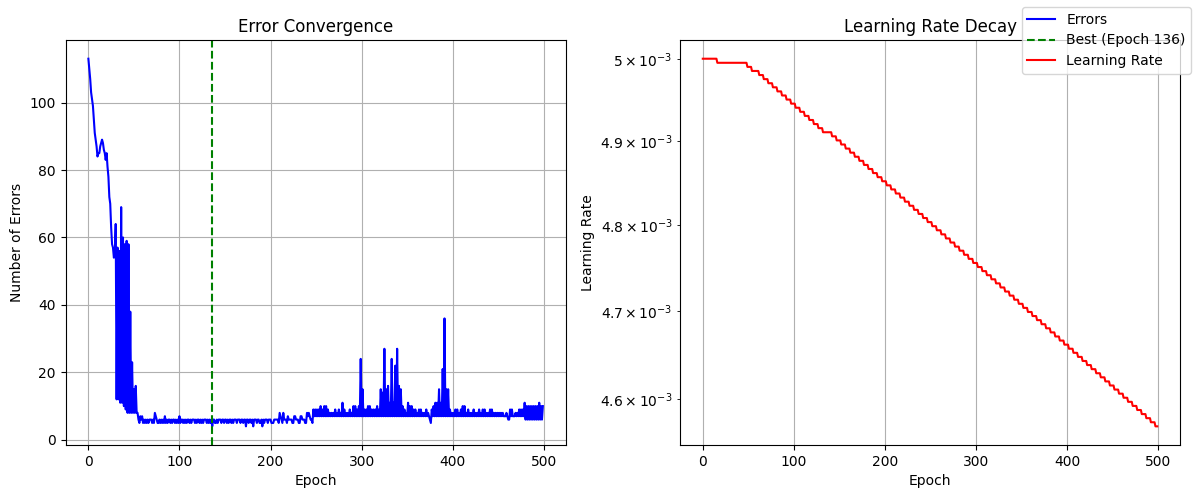

Run 3 Score: 0.9375

Run 4 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Run 4 Best Params: {'decay_factor': 0.999, 'epochs': 500, 'lambda_scaling': 'sqrt', 'learning_rate': 0.001, 'n_control_points': 6, 'patience': 10}
Animation saved to ./animations/4.gif


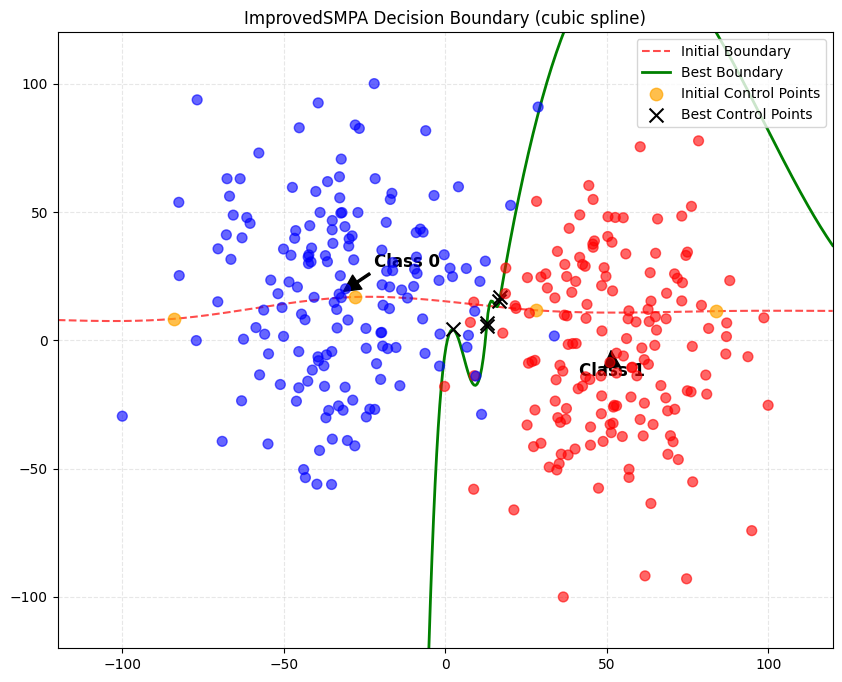

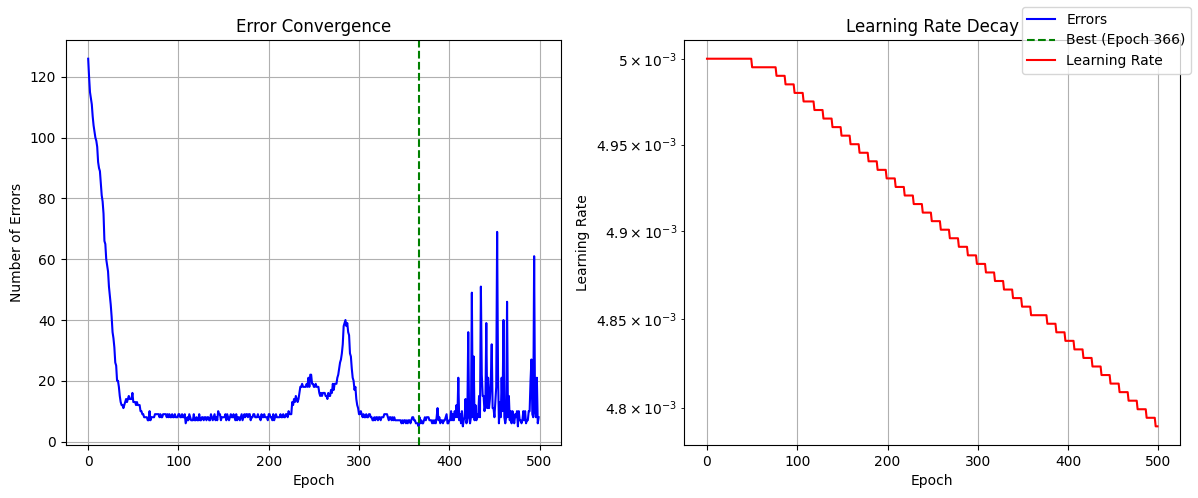

Run 4 Score: 0.9625

Run 0 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Run 0 Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Run 0 Score: 0.9625

Run 1 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Run 1 Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Run 1 Score: 0.9750

Run 2 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Run 2 Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Run 2 Score: 0.9625

Run 3 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Run 3 Best Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Run 3 Score: 0.9625

Run 4 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 20 candidat

In [7]:
comparison = ClassifierComparison(X, y)

# Run all classifiers on same split
classifiers = ['smpa', 'svm', 'rf', 'dt']
results = {}
for clf_type in classifiers:
    results[clf_type] = comparison.stability_test(clf_type, n_runs=5)

for clf_type, res in results.items():
    print(f"\n📊 {clf_type.upper()} Stability:")
    print(f"Mean Score: {res['mean_score']:.4f}")
    print(f"Score Std Dev: {res['std_score']:.4f}")

comparison.statistical_significance_test(results, target='smpa')